## Load files

Updated May 19

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install lifelines umap-learn > /dev/null 2>&1

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict
import tifffile as tf
from scipy.stats import ttest_ind
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

In [ ]:
read_tile_size = 64
num_channels = 37

folder = 'tiles_extended'

image_mean = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/image_mean.npy', allow_pickle=True)
tile_location = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/tile_location.npy', allow_pickle=True)
sample_name = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/sample_name.npy', allow_pickle=True)
embedding_mean = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/embedding_mean.npy', allow_pickle=True)

import numpy as np

cells_folder = 'cells_full'

# Load the data from the appropriate folder
cells_tile_location = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{cells_folder}/tile_location.npy', allow_pickle=True)
cells_sample_name = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{cells_folder}/sample_name.npy', allow_pickle=True)
cells_celltype_array = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{cells_folder}/celltypes.npy', allow_pickle=True)
cells_boundaries = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{cells_folder}/boundaries.npy', allow_pickle=True)

import json
cell_tile_location_processed = [list(map(int, loc.tolist()))[::-1] for loc in cells_tile_location]
cell_boundaries_processed = [list(map(lambda x: x[::-1], json.loads(b))) for b in cells_boundaries]

n_cell_clusters = 40
cells_labels = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{cells_folder}/labels_{n_cell_clusters}.npy', allow_pickle=True)

marker_names = ['CD117', 'CD11c', 'CD14', 'CD163', 'CD16', 'CD20', 'CD31', 'CD3', 'CD4', 'CD68', 'CD8', 'CD94', 'DNA1', 'FoxP3', 'GFAP', 'HLA-DR', 'MPO', 'Olig2', 'P2PY12', 'Sox2', 'Sox9', 'Ki67', 'HIF1a', 'CD45', 'CD206', 'MMP9', 'pSTAT3', 'Ox40L', 'CD39', 'CD40', 'c-Caspase3', 'Claudin5', 'MeLanA', 'PMEL', 'PanCK', 'CIRP', 'pERK']

# Create the DataFrame
cell_df = pd.DataFrame({
    'sample_name': cells_sample_name,
    'cell_type': cells_celltype_array,
    'tile_location': cell_tile_location_processed,
    'boundary': cell_boundaries_processed,
    'cell_label': cells_labels
})

In [ ]:
cells_image_mean = np.load(f'/content/drive/MyDrive/canvas/channels{num_channels}/{cells_folder}/image_mean.npy', allow_pickle=True)

# Add image_mean data as separate columns for each marker
for i, marker in enumerate(marker_names):
    cell_df[marker] = cells_image_mean[:, i]

cell_df[marker_names] = (cell_df[marker_names] - cell_df[marker_names].min()) / (cell_df[marker_names].max() - cell_df[marker_names].min())


In [ ]:
mask = np.array(['N' not in name for name in sample_name])

# Apply mask and overwrite the original arrays with the filtered data
image_mean = image_mean[mask]
tile_location = tile_location[mask]
sample_name = sample_name[mask]
embedding_mean = embedding_mean[mask]

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans

# Define the path where you want to save the KMeans labels
kmeans_save_path = f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/'

n_clusters = 40

# Check if the KMeans labels already exist
labels_filename = os.path.join(kmeans_save_path, f'labels_{n_clusters}.npy')
if os.path.exists(labels_filename):
    # Load the existing KMeans labels
    labels = np.load(labels_filename, allow_pickle=True)
    print(f'Using existing KMeans labels: {labels_filename}')
else:
    # Generate new KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedding_mean)
    # Save the KMeans labels
    np.save(labels_filename, kmeans.labels_)
    print(f'New KMeans labels generated and saved: {labels_filename}')
    labels = kmeans.labels_

Using existing KMeans labels: /content/drive/MyDrive/canvas/channels37/tiles_extended/labels_40.npy


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Process tile_location to convert tensor to plain array and swap coordinates
tile_location_processed = [list(map(int, loc.tolist()))[::-1] for loc in tile_location]

# Create DataFrame
master_df = pd.DataFrame({
    'sample_name': sample_name,
    'labels': labels,
    'tile_location': tile_location_processed,
})

celltype_colors = {
    'Alt BMDM': '#1f77b4',
    'Alt MG': '#aec7e8',
    'Astrocytes': '#ff7f0e',
    'B cell': '#ffbb78',
    'Cancer': '#2ca02c',
    'Cl BMDM': '#98df8a',
    'Cl MG': '#d62728',
    'Cl Mo': '#ff9896',
    'DCs cell': '#9467bd',
    'Endothelial cell': '#c5b0d5',
    'Int Mo': '#8c564b',
    'Mast cell': '#c49c94',
    'NK cell': '#e377c2',
    'Neutrophils': '#f7b6d2',
    'Non-Cl Mo': '#7f7f7f',
    'T other': '#c7c7c7',
    'Tc': '#bcbd22',
    'Th': '#dbdb8d',
    'Treg': '#17becf',
    'Unknown': '#9edae5'
}

# Combine tab20 and tab20b colors
tab20_colors = plt.get_cmap('tab20').colors
tab20b_colors = plt.get_cmap('tab20b').colors
combined_colors = tab20_colors + tab20b_colors

marker_names = ['CD117', 'CD11c', 'CD14', 'CD163', 'CD16', 'CD20', 'CD31', 'CD3', 'CD4', 'CD68', 'CD8', 'CD94', 'DNA1', 'FoxP3', 'GFAP', 'HLA-DR', 'MPO', 'Olig2', 'P2PY12', 'Sox2', 'Sox9', 'Ki67', 'HIF1a', 'CD45', 'CD206', 'MMP9', 'pSTAT3', 'Ox40L', 'CD39', 'CD40', 'c-Caspase3', 'Claudin5', 'MeLanA', 'PMEL', 'PanCK', 'CIRP', 'pERK']

# Assign colors to markers
marker_colors = dict(zip(marker_names, combined_colors[:37]))

# Determine the markers and colormap to use based on the number of channels
num_channels = image_mean.shape[1]

# Add image_mean data as separate columns for each marker
for i, marker in enumerate(marker_names):
    master_df[marker] = image_mean[:, i]

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans

conditions = ['Astrocytoma', 'Glioblastoma', 'Primary_Bladder', 'Primary_Breast', 'Primary_Colorectal', 'Primary_Gastric', 'Primary_Gastro-intestinal', 'Primary_Lung', 'Primary_Melanoma', 'Primary_Ovarian', 'Glioma Unknown IDH']

patient_df = pd.read_csv('/content/drive/MyDrive/canvas/Clinical Data GBM BrM.csv')

# Process patient_df
patient_df['Event'] = patient_df['OS event (days post surgery)'].apply(lambda x: 1 if 'death' in str(x) else 0)
patient_df['Survival Duration'] = patient_df['OS event (days post surgery)'].str.extract(r'\((\d+)\)').astype(float)
patient_df = patient_df[['Patient ID', 'Age', 'Sex', 'Event', 'Survival Duration', 'Primary Site of Brain Metastasis', 'Tumor Type', 'Local Recurrence (days post surgery)', 'MGMT status']]
patient_df = patient_df.rename(columns={'Patient ID': 'patient_id'})


patient_df['Age'] = pd.to_numeric(patient_df['Age'], errors='coerce')
patient_df['Sex'] = patient_df['Sex'].replace({'F': 1, 'M': 0})

# Adding new condition-based columns
patient_df['Local Recurrence'] = patient_df['Local Recurrence (days post surgery)'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)

# Dropping original columns no longer needed for analysis
patient_df = patient_df.drop(columns=['Local Recurrence (days post surgery)'])
patient_df = pd.get_dummies(patient_df, columns=['Primary Site of Brain Metastasis'], prefix='Primary', dtype=int)
patient_df = pd.get_dummies(patient_df, columns=['Tumor Type'], prefix='', prefix_sep='', dtype=int)

patient_df = patient_df.drop_duplicates(subset=['patient_id'], keep='first')
# Map values: "m" -> 1, "um" -> 0, and keep NaN values as NaN
patient_df['MGMT status'] = patient_df['MGMT status'].map({'m': 1, 'um': 0}).astype('Int64')

In [ ]:
sample_label_df = pd.DataFrame({'sample_name': sample_name, 'labels': labels})
sample_label_pivot = sample_label_df.groupby(['sample_name', 'labels']).size().unstack(fill_value=0)
sample_label_pivot = sample_label_pivot.reset_index()
sample_label_pivot = sample_label_pivot.rename_axis(None, axis=1)
sample_label_pivot['patient_id'] = np.array([re.match(r"(Glioma|BrM)_[0-9]+", name).group() if re.match(r"(Glioma|BrM)_[0-9]+", name) else None for name in sample_label_pivot['sample_name']])

# Add the 'cmn' column based on the content of 'sample_name'
sample_label_pivot['cmn'] = sample_label_pivot['sample_name'].apply(
    lambda name: 'Core' if 'C' in name else 'Margin' if 'M' in name else 'Normal' if 'N' in name else None
)

# Drop the 'sample_name' column if it exists
if 'sample_name' in sample_label_pivot.columns:
    sample_label_pivot = sample_label_pivot.drop(columns=['sample_name'])

# Group by 'patient_id' and 'cmn', summing the values for each combination
sample_label_pivot = sample_label_pivot.groupby(['patient_id', 'cmn']).sum().reset_index()

# Check if 'All' rows already exist
if not any(sample_label_pivot['cmn'] == 'All'):
    # Group by 'patient_id' and sum the values across 'Core', 'Margin', and 'Normal'
    all_rows = sample_label_pivot.groupby('patient_id').sum().reset_index()
    all_rows['cmn'] = 'All'

    # Append the 'All' rows to the original DataFrame
    sample_label_pivot = pd.concat([sample_label_pivot, all_rows], ignore_index=True)

# Sort by 'patient_id' to keep the order
sample_label_pivot = sample_label_pivot.sort_values(by=['patient_id', 'cmn']).reset_index(drop=True)

sample_label_pivot_norm = sample_label_pivot.set_index(['patient_id', 'cmn'])
sample_label_pivot_norm = sample_label_pivot_norm.div(sample_label_pivot_norm.sum(axis=1), axis=0).reset_index()

sample_label_pivot_norm = pd.merge(
    sample_label_pivot_norm,
    patient_df[['Event', 'Survival Duration', 'patient_id']],
    left_on='patient_id',
    right_on='patient_id',
    how='left'
)

sample_label_pivot_norm_clean = sample_label_pivot_norm.dropna(subset=['Survival Duration', 'Event'])

# Display the updated DataFrame
sample_label_pivot_norm_clean

,patient_id,cmn,0,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,Event,Survival Duration
0,BrM_001,All,0.000000,0.115183,0.000000,0.000000,0.047120,0.000000,0.104712,0.005236,...,0.000000,0.000000,0.251309,0.000000,0.000000,0.000000,0.000000,0.000000,1,2063.0
1,BrM_001,Core,0.000000,0.148148,0.000000,0.000000,0.027778,0.000000,0.175926,0.009259,...,0.000000,0.000000,0.185185,0.000000,0.000000,0.000000,0.000000,0.000000,1,2063.0
2,BrM_001,Margin,0.000000,0.072289,0.000000,0.000000,0.072289,0.000000,0.012048,0.000000,...,0.000000,0.000000,0.337349,0.000000,0.000000,0.000000,0.000000,0.000000,1,2063.0
3,BrM_002,All,0.000000,0.079470,0.000000,0.000000,0.079470,0.000000,0.066225,0.000000,...,0.000000,0.000000,0.145695,0.000000,0.000000,0.000000,0.000000,0.000000,1,28.0
4,BrM_002,Core,0.000000,0.066667,0.000000,0.000000,0.050000,0.000000,0.166667,0.000000,...,0.000000,0.000000,0.216667,0.000000,0.000000,0.000000,0.000000,0.000000,1,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,Glioma_137,Core,0.000000,0.000000,0.015748,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.055118,0.188976,0.000000,0.000000,0.031496,0.015748,0.007874,0.055118,1,2904.0
405,Glioma_138,All,0.000000,0.000000,0.023529,0.023529,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.058824,0.000000,0.000000,0.117647,0.058824,0.070588,0.000000,1,2048.0
406,Glioma_138,Core,0.000000,0.000000,0.023529,0.023529,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.058824,0.000000,0.000000,0.117647,0.058824,0.070588,0.000000,1,2048.0
407,Glioma_139,All,0.034483,0.000000,0.034483,0.019704,0.000000,0.014778,0.000000,0.000000,...,0.206897,0.000000,0.000000,0.004926,0.009852,0.000000,0.024631,0.000000,1,1340.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import pickle

# Load cluster_celltype_counts from the pickle file
with open(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/tile_celltype_counts_{n_clusters}.pkl', 'rb') as file:
    cluster_celltype_counts = pickle.load(file)

# Remove empty clusters if any
if any(not v for v in cluster_celltype_counts.values()):
    cluster_celltype_counts = {k: v for k, v in cluster_celltype_counts.items() if v}

# Convert cluster_celltype_counts to DataFrame
celltype_df = pd.DataFrame(cluster_celltype_counts).fillna(0).T

# Ensure the cell types are in alphabetical order
celltype_df = celltype_df[sorted(celltype_df.columns)]

# Normalize celltype_df for percentages
percentages = celltype_df.div(celltype_df.sum(axis=1), axis=0) * 100

# Determine the dominant cell type for each module using a fixed threshold of 50%
dominant_cell_types = percentages.idxmax(axis=1)
dominant_cell_types_percent = percentages.max(axis=1)
dominant_cell_types = dominant_cell_types.where(dominant_cell_types_percent > 40, other='Mixed')

# Create a DataFrame for marker data and apply min-max normalization
marker_df = master_df[marker_names]
normalized_df = (marker_df - marker_df.min()) / (marker_df.max() - marker_df.min())

# Apply clipping based on the 2nd and 98th percentiles
clipped_df = normalized_df #.clip(lower=normalized_df.quantile(0.02), upper=normalized_df.quantile(0.98), axis=1)

# Combine the name and marker dataframes
labels_df = master_df[['sample_name', 'labels']].copy()
labels_df.columns = ['Sample', 'Cluster']

markers_by_sample_df = pd.concat([labels_df, clipped_df], axis=1)

# Group by Cluster and sum the values
markers_by_module_df = markers_by_sample_df.groupby('Cluster').sum()
markers_by_module_df = markers_by_module_df.drop('Sample', axis=1)

# Exclude DNA1 marker from the analysis
#if 'DNA1' in markers_by_module_df.columns:
#    markers_by_module_df = markers_by_module_df.drop(columns='DNA1')

# Perform clustering by cell type first, then hierarchical clustering within each cell type cluster
ordered_modules = []
for cell_type in dominant_cell_types.unique():
    modules_in_cluster = percentages[dominant_cell_types == cell_type]
    if len(modules_in_cluster) > 1:
        dendrogram = sch.dendrogram(sch.linkage(modules_in_cluster, method='ward'), no_plot=True)
        ordered_cluster = [modules_in_cluster.index[i] for i in dendrogram['leaves']]
        ordered_modules.extend(ordered_cluster)
    else:
        ordered_modules.extend(modules_in_cluster.index)

# Reorder the rows of the DataFrame according to the clustering
percentages = percentages.loc[ordered_modules]
markers_by_module_df = markers_by_module_df.loc[ordered_modules]

# Normalize for percentage calculation
signature_df = markers_by_module_df.div(markers_by_module_df.sum(axis=1), axis=0) * 100

# Determine enriched markers
enriched_markers = (signature_df >= signature_df.quantile(0.90)).astype(int)

In [ ]:
master_df['patient_id'] = np.array([re.match(r"(Glioma|BrM)_[0-9]+", name).group() if re.match(r"(Glioma|BrM)_[0-9]+", name) else None for name in master_df['sample_name']])

In [ ]:
import pandas as pd

# Assuming master_df is already defined

# Initialize lists to store the counts
glioma_tiles = []
brm_tiles = []
glioma_tiles_normalized = []
brm_tiles_normalized = []
glioma_patients = []
brm_patients = []
dominance = []

# Set the cluster labels from 0 to 49 as the index
cluster_labels = range(n_clusters)

# Calculate the total number of tiles for Glioma and BrM
total_glioma_tiles = master_df[master_df['sample_name'].str.startswith('Glioma')].shape[0]
total_brm_tiles = master_df[master_df['sample_name'].str.startswith('BrM')].shape[0]

# Iterate over each cluster label
for cluster in cluster_labels:
    # Filter the rows for the current cluster
    cluster_df = master_df[master_df['labels'] == cluster]

    # Count the number of tiles for Glioma and BrM in this cluster
    glioma_count = cluster_df[cluster_df['sample_name'].str.startswith('Glioma')].shape[0]
    brm_count = cluster_df[cluster_df['sample_name'].str.startswith('BrM')].shape[0]

    # Normalize the counts to 1,000,000 based on their respective totals, cast to integers
    glioma_normalized = int((glioma_count / total_glioma_tiles) * 1000000) if total_glioma_tiles > 0 else 0
    brm_normalized = int((brm_count / total_brm_tiles) * 1000000) if total_brm_tiles > 0 else 0

    # Group by patient and count the number of patients with at least 5 tiles for Glioma and BrM
    glioma_patient_count = (cluster_df[cluster_df['sample_name'].str.startswith('Glioma')]
                            .groupby('patient_id')
                            .size() >= 5).sum()

    brm_patient_count = (cluster_df[cluster_df['sample_name'].str.startswith('BrM')]
                         .groupby('patient_id')
                         .size() >= 5).sum()

    # Determine dominance using integer comparison
    total_normalized = glioma_normalized + brm_normalized
    if total_normalized == 0:
        dominance.append('Mixed')  # If both counts are 0, mark dominance as 'Mixed'
    elif glioma_normalized >= 0.9 * total_normalized:
        dominance.append('Glioma')
    elif brm_normalized >= 0.9 * total_normalized:
        dominance.append('BrM')
    else:
        dominance.append('Mixed')

    # Append the counts to the lists
    glioma_tiles.append(int(glioma_count))
    brm_tiles.append(int(brm_count))
    glioma_tiles_normalized.append(int(glioma_normalized))
    brm_tiles_normalized.append(int(brm_normalized))
    glioma_patients.append(int(glioma_patient_count))
    brm_patients.append(int(brm_patient_count))

# Create the final DataFrame with cluster labels as index
tile_counts_df = pd.DataFrame({
    'Glioma Tiles': glioma_tiles,
    'BrM Tiles': brm_tiles,
    'Glioma Tiles (Normalized to 1M)': glioma_tiles_normalized,
    'BrM Tiles (Normalized to 1M)': brm_tiles_normalized,
    'Glioma Patients (>=5 Tiles)': glioma_patients,
    'BrM Patients (>=5 Tiles)': brm_patients,
    'Dominance': dominance
}, index=cluster_labels)

# Add a row at the bottom to total the tiles and patients (excluding the Dominance column)
tile_counts_df.loc['Total'] = tile_counts_df.drop(columns=['Dominance']).sum()

# Ensure all values are integers (for safety)
tile_counts_df = tile_counts_df.astype({col: 'int' for col in tile_counts_df.columns if col != 'Dominance'})

## Cox/Kaplan

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
from lifelines.utils import concordance_index
from sklearn.utils import resample

# Function to compute bootstrap confidence intervals
def bootstrap_c_index(y_true, y_pred, event_observed, n_bootstraps=1000, ci_level=0.95):
    """Calculate C-index with bootstrap confidence intervals."""
    c_index_values = []

    for _ in range(n_bootstraps):
        # Resample with replacement
        y_true_resampled, y_pred_resampled, event_observed_resampled = resample(
            y_true, y_pred, event_observed, replace=True
        )

        # Compute C-index for the resampled data
        c_index_resampled = concordance_index(y_true_resampled, y_pred_resampled, event_observed_resampled)
        c_index_values.append(c_index_resampled)

    # Calculate the confidence intervals
    alpha = (1.0 - ci_level) / 2.0
    lower_ci = np.percentile(c_index_values, 100 * alpha)
    upper_ci = np.percentile(c_index_values, 100 * (1.0 - alpha))

    return np.mean(c_index_values), lower_ci, upper_ci

# Step 1: Filter where cmn = 'All'
filtered_sample_label_pivot_norm = sample_label_pivot_norm_clean[sample_label_pivot_norm_clean['cmn'] == 'All'].copy()

# Step 2: Divide patients by BrM, Glioma, or All
def assign_patient_type(patient_id):
    if patient_id.startswith('BrM'):
        return 'BrM'
    elif patient_id.startswith('Glioma'):
        return 'Glioma'
    else:
        return 'All'

filtered_sample_label_pivot_norm.loc[:, 'type'] = filtered_sample_label_pivot_norm['patient_id'].apply(assign_patient_type)

# Step 3, 4, and 5: Calculate C-index and create c-index DataFrame
c_index_df = pd.DataFrame(columns=[
    'c-index', 'type', 'c-index_low', 'c-index_high',
    'cluster', 'c-index_coef', 'c-index_direction'
])

# Get the list of clusters (excluding 'patient_id', 'cmn', 'type', 'Event', 'Survival Duration')
clusters = filtered_sample_label_pivot_norm.columns[2:-3]

# Iterate over each cluster
for cluster in clusters:
    # Iterate through BrM and Glioma first
    for patient_type in ['BrM', 'Glioma']:
        # Filter by patient type
        patient_subset = filtered_sample_label_pivot_norm[filtered_sample_label_pivot_norm['type'] == patient_type]

        # Ensure we have enough patients to run the analysis
        if len(patient_subset) < 10:
            continue

        # Step 4: Calculate the C-index and bootstrap CIs
        y_true = patient_subset['Survival Duration']
        event_observed = patient_subset['Event']
        y_pred = patient_subset[cluster]

        # Compute C-index and confidence intervals using bootstrapping
        c_index, c_index_low, c_index_high = bootstrap_c_index(y_true, y_pred, event_observed)

        # Calculate coefficient and direction based on simple linear regression-like approach
        coef = np.corrcoef(y_pred, y_true)[0, 1]
        direction = 'positive' if coef > 0 else 'negative'

        # Step 5: Append results to c_index_df
        new_row = pd.DataFrame({
            'c-index': [c_index],
            'type': [patient_type],
            'c-index_low': [c_index_low],
            'c-index_high': [c_index_high],
            'cluster': [cluster],
            'c-index_coef': [coef],
            'c-index_direction': [direction]
        })
        c_index_df = pd.concat([c_index_df, new_row], ignore_index=True)

    # Now handle the "All" case by including both BrM and Glioma patients
    all_patient_subset = filtered_sample_label_pivot_norm[filtered_sample_label_pivot_norm['type'].isin(['BrM', 'Glioma'])]

    # Ensure we have enough patients to run the analysis
    if len(all_patient_subset) < 10:
        continue

    # Step 4: Calculate the C-index and bootstrap CIs for All patients
    y_true_all = all_patient_subset['Survival Duration']
    event_observed_all = all_patient_subset['Event']
    y_pred_all = all_patient_subset[cluster]

    c_index_all, c_index_low_all, c_index_high_all = bootstrap_c_index(y_true_all, y_pred_all, event_observed_all)

    # Calculate coefficient and direction
    coef_all = np.corrcoef(y_pred_all, y_true_all)[0, 1]
    direction_all = 'positive' if coef_all > 0 else 'negative'

    # Append the "All" result to c_index_df
    new_row_all = pd.DataFrame({
        'c-index': [c_index_all],
        'type': ['All'],
        'c-index_low': [c_index_low_all],
        'c-index_high': [c_index_high_all],
        'cluster': [cluster],
        'c-index_coef': [coef_all],
        'c-index_direction': [direction_all]
    })
    c_index_df = pd.concat([c_index_df, new_row_all], ignore_index=True)

# Display the final c_index_df
c_index_df

,c-index,type,c-index_low,c-index_high,cluster,c-index_coef,c-index_direction
0,0.500000,BrM,0.500000,0.500000,0,NaN,negative
1,0.445282,Glioma,0.384955,0.508301,0,-0.070037,negative
2,0.459191,All,0.406647,0.508436,0,-0.004337,negative
3,0.514788,BrM,0.364359,0.660309,1,-0.167079,negative
4,0.500000,Glioma,0.500000,0.500000,1,NaN,negative
...,...,...,...,...,...,...,...
115,0.570001,Glioma,0.519570,0.622208,38,0.188312,positive
116,0.551686,All,0.512348,0.590102,38,0.204236,positive
117,0.500000,BrM,0.500000,0.500000,39,NaN,negative
118,0.467127,Glioma,0.398483,0.538972,39,0.054247,positive


In [ ]:
import pandas as pd
from lifelines import CoxPHFitter

# Step 1: Filter and select columns for the Cox model in one step
# Assuming cluster columns range from 0 to 39 and are integers, adjust if necessary
cluster_cols = list(range(40))  # Adjust based on actual cluster columns
cox_data = sample_label_pivot_norm_clean.loc[
    sample_label_pivot_norm_clean['cmn'] == 'All',
    ['Survival Duration', 'Event'] + cluster_cols
]

# Rename columns for compatibility
cox_data = cox_data.rename(columns={'Survival Duration': 'survival_time', 'Event': 'event'})

# Step 2: Set up the CoxPHFitter with elastic net penalty
# Adjust penalizer and l1_ratio for the strength and balance of regularization
cox_model = CoxPHFitter(penalizer=0.1, l1_ratio=0.5)  # You may adjust these parameters

# Step 3: Fit the Cox model
cox_model.fit(cox_data, duration_col='survival_time', event_col='event')

# Display the summary of results
cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 149 total observations, 21 right-censored observations>
             duration col = 'survival_time'
                event col = 'event'
                penalizer = 0.1
                 l1 ratio = 0.5
      baseline estimation = breslow
   number of observations = 149
number of events observed = 128
   partial log-likelihood = -501.94
         time fit was run = 2025-01-31 18:50:09 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
0           0.00      1.00      0.00           -0.00            0.00                1.00                1.00
1          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
2         -15.07      0.00      4.87          -24.62           -5.52                0.00                0.00
3           0.57      1.77      1.52           -2.41            3.54                0.09               34.59
4          -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
5          -0.05      0.96      0.73           -1.48            1.39                0.23                4.02
6          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
7          -0.30      0.74      2.44           -5.08            4.49                0.01               88.96
8           0.00      1.00      0.01           -0.02            0.02                0.98                1.02
9           0.00      1.00      0.00           -0.00            0.00                1.00                1.00
10          1.81      6.12      1.49           -1.11            4.73                0.33              113.36
11         -1.15      0.32      2.12           -5.31            3.01                0.00               20.21
12          0.00      1.00      0.00           -0.01            0.01                0.99                1.01
13         -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
14          1.74      5.72      2.31           -2.79            6.28                0.06              533.81
15         -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
16         -0.35      0.71      1.60           -3.48            2.78                0.03               16.20
17          1.54      4.67      1.59           -1.58            4.66                0.21              105.54
18          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
19         -1.72      0.18      3.15           -7.88            4.45                0.00               85.85
20          0.62      1.86      1.30           -1.92            3.16                0.15               23.63
21         -1.25      0.29      3.83           -8.75            6.25                0.00              517.95
22         -0.20      0.82      1.21           -2.58            2.17                0.08                8.76
23         -0.90      0.40      2.35           -5.51            3.70                0.00               40.31
24         -2.50      0.08      3.80           -9.94            4.95                0.00              141.50
25         -3.31      0.04      2.03           -7.30            0.68                0.00                1.97
26          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
27         -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
28          0.00      1.00      0.00           -0.00            0.00                1.00                1.00
29          0.00      1.00      0.00           -0.01            0.01                0.99                1.01
30          1.17      3.23      1.33           -1.43            3.78               

## Composition

In [ ]:
import pandas as pd

# Function to extract patient name from sample_name
def extract_patient_id(sample_name):
    if 'BrM' in sample_name:
        return sample_name.split('_')[0] + '_' + sample_name.split('_')[1][:3]
    elif 'Glioma' in sample_name:
        return sample_name.split('_')[0] + '_' + sample_name.split('_')[1][:3]
    else:
        return None

# Add a new column to master_df for the patient name
master_df['patient_id'] = master_df['sample_name'].apply(extract_patient_id)

# List of condition columns in patient_df
condition_columns = ['Primary_Bladder', 'Primary_Breast', 'Primary_Colorectal',
                     'Primary_Gastric', 'Primary_Gastro-intestinal', 'Primary_Lung',
                     'Primary_Melanoma', 'Primary_Ovarian', 'Astrocytoma',
                     'Glioblastoma', 'Glioma Unknown IDH']

# Function to get condition type based on patient name
def get_condition_type(patient_id):
    if patient_id in patient_df.index:  # Ensure patient_id exists in patient_df
        patient_row = patient_df.loc[patient_id]
        for condition in condition_columns:
            if patient_row[condition] == 1:
                return condition
    return None

# Add the 'condition type' column to master_df
master_df['condition type'] = master_df['patient_id'].apply(get_condition_type)

# Drop the helper 'patient_id' column as it's no longer needed
master_df = master_df.drop(columns=['patient_id'])

# Display the updated master_df
master_df.head()

,sample_name,labels,tile_location,CD117,CD11c,CD14,CD163,CD16,CD20,CD31,...,CD39,CD40,c-Caspase3,Claudin5,MeLanA,PMEL,PanCK,CIRP,pERK,condition type
0,Glioma_083C2,26,"[64, 0]",-0.311412,0.269393,-0.336939,-0.307517,-0.217484,-0.169645,-0.242500,...,-0.060927,-0.137759,-0.111699,0.110904,-0.250068,-0.263216,-0.460689,-0.375582,-0.361757,None
1,Glioma_083C2,32,"[128, 0]",-0.311412,1.126296,-0.336939,-0.302287,-0.038458,-0.169645,-0.242500,...,-0.150886,-0.092111,-0.100340,-0.180838,-0.250068,-0.263216,-0.460689,-0.375582,-0.361757,None
2,Glioma_083C2,32,"[320, 0]",-0.311412,0.726611,-0.336939,-0.307517,-0.083180,-0.169645,-0.170640,...,-0.113426,-0.130151,-0.085195,-0.111368,-0.250068,-0.263216,-0.460689,-0.375582,-0.361757,None
3,Glioma_083C2,32,"[384, 0]",-0.311412,0.538438,-0.336939,-0.307517,-0.051540,-0.169645,0.100571,...,-0.070115,-0.001347,-0.028400,0.127219,-0.250068,-0.263216,-0.460689,-0.375582,-0.361757,None
4,Glioma_083C2,32,"[512, 0]",-0.311412,1.660619,-0.336939,-0.284197,0.252414,-0.169645,0.043611,...,-0.019618,-0.025586,-0.040895,0.080577,-0.250068,-0.263216,-0.460689,-0.375582,-0.361757,None


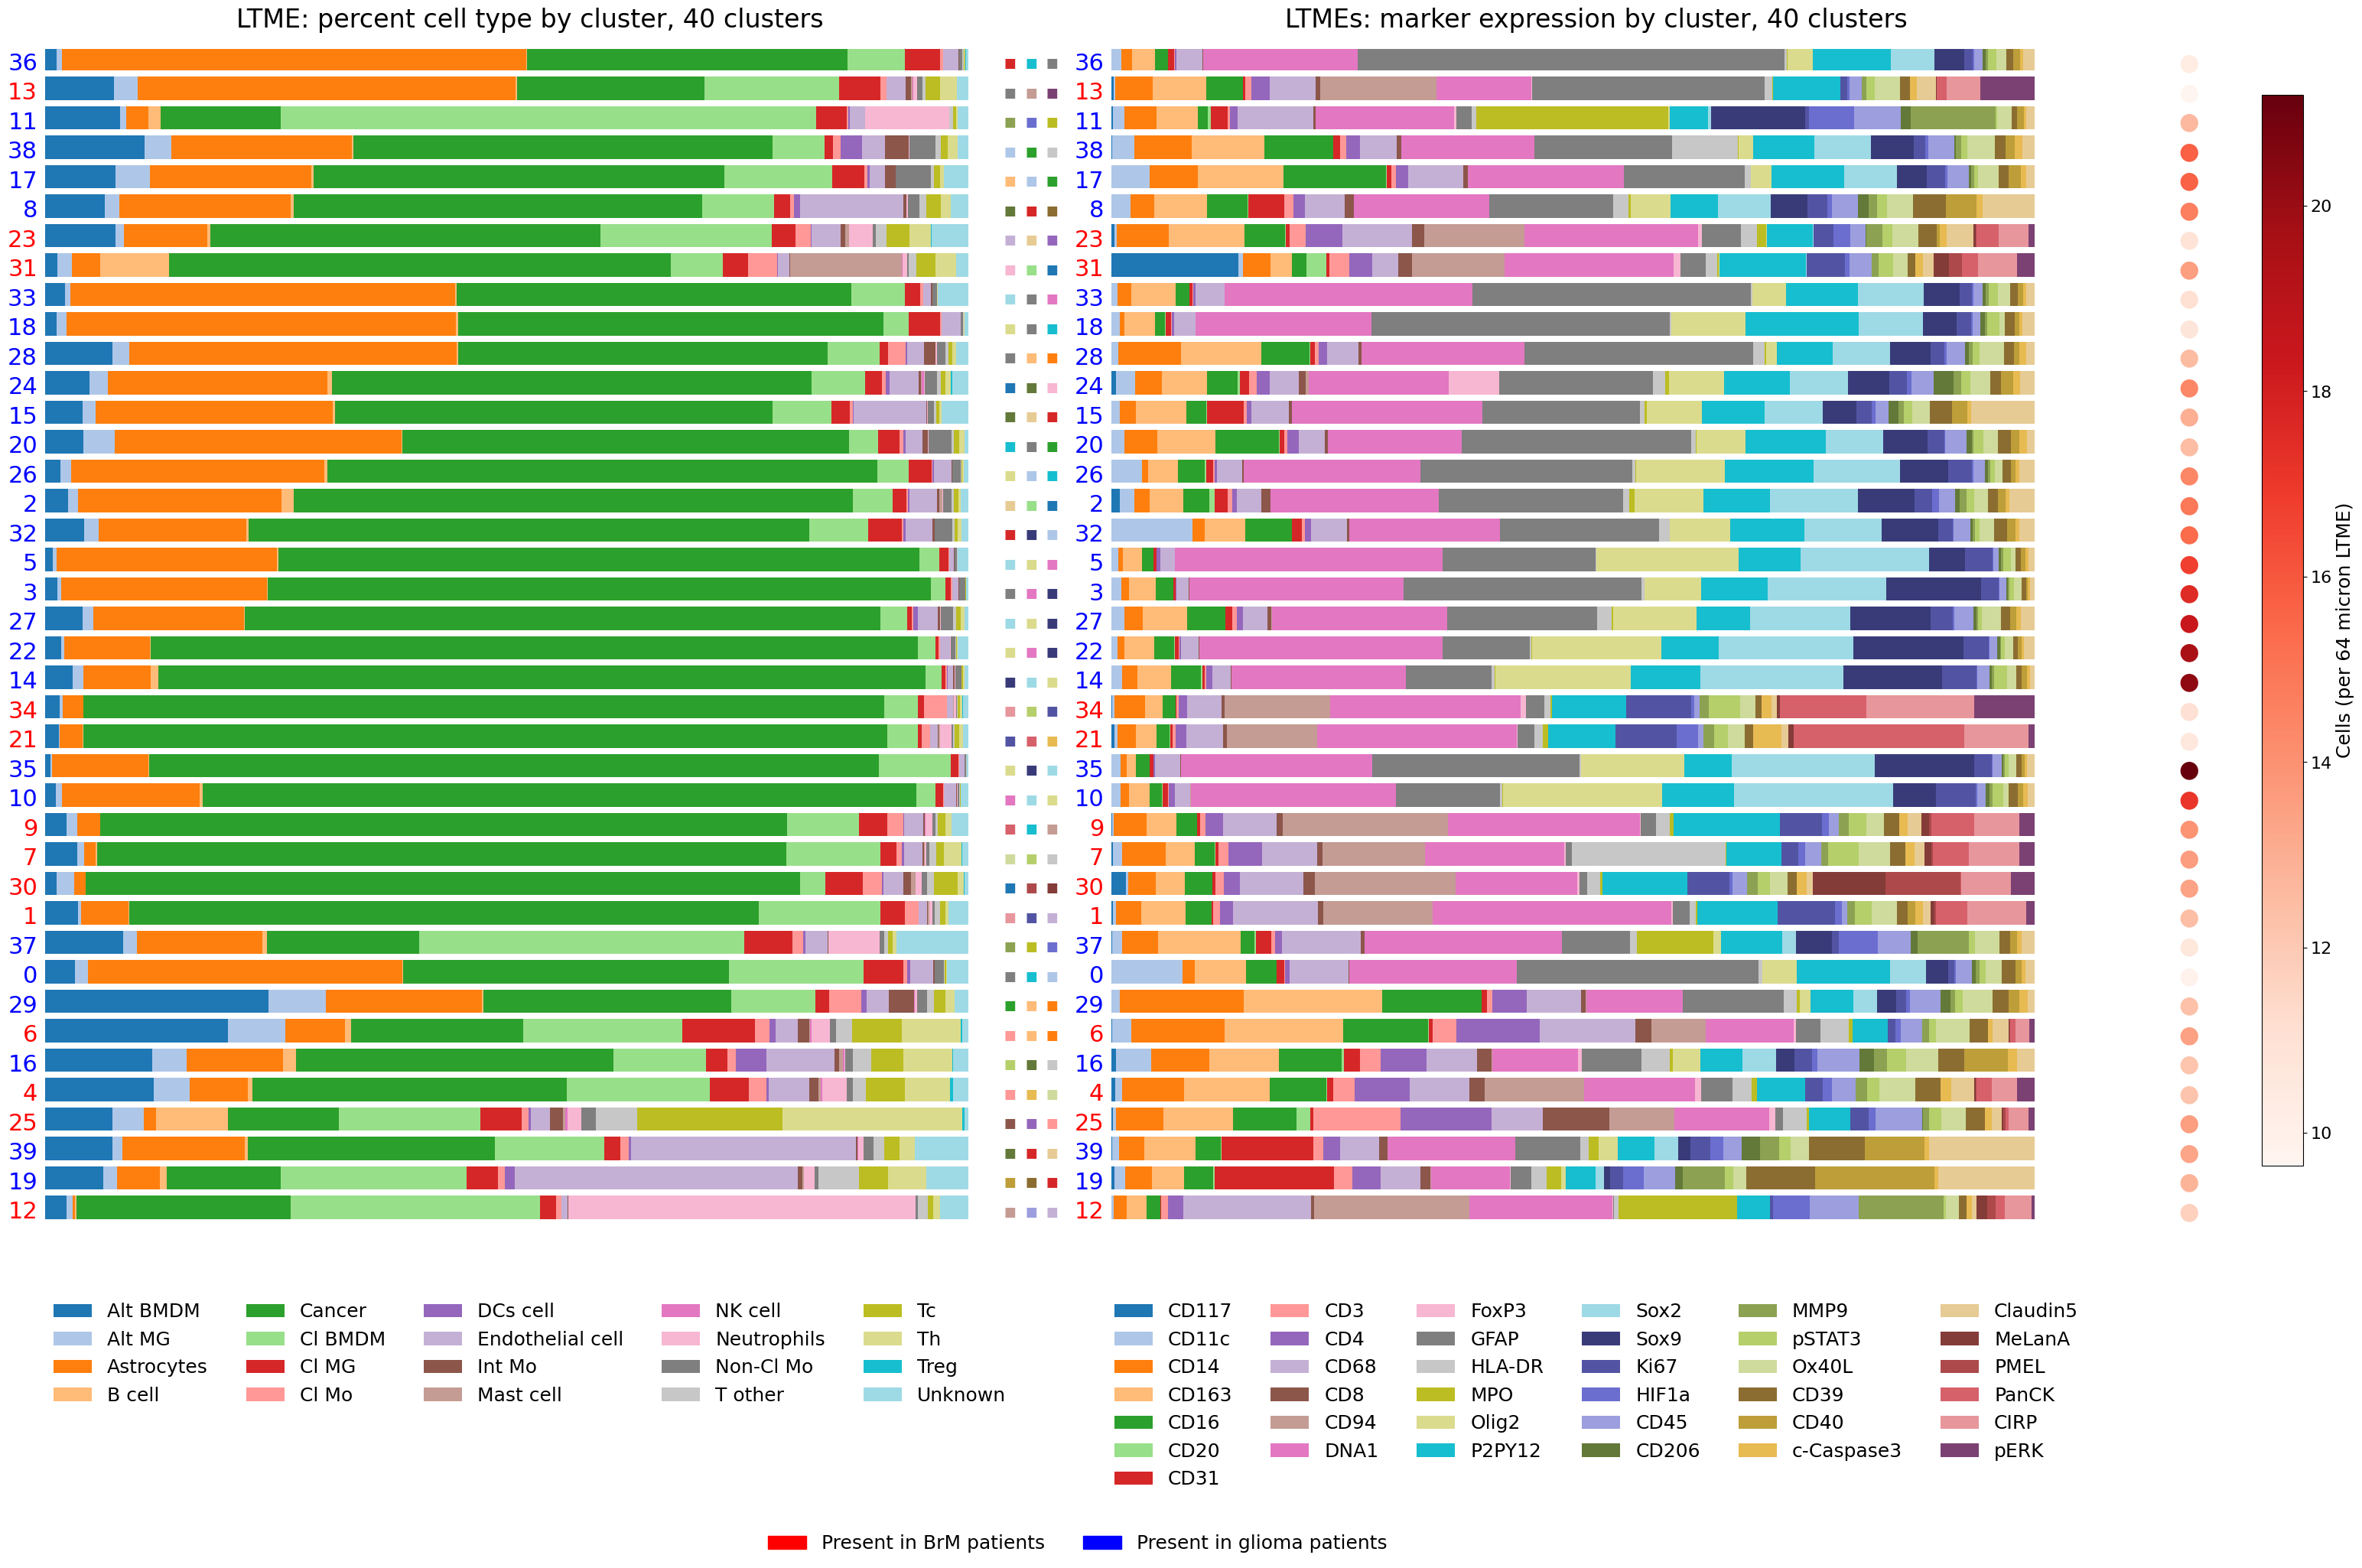

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Ensure the marker DataFrame is in the same order as the composition DataFrame
signature_df = signature_df.reindex(percentages.index)

# Generate the plots side by side using Matplotlib with an extra subplot for the density circles
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36, 20), gridspec_kw={'width_ratios': [10, 10, 0.01]})  # Give more space to plots 1 and 2

# Plot normalized percentages of cell types
percentages.plot(kind='barh', stacked=True, ax=axes[0], colormap='tab20')
for container in axes[0].containers:
    plt.setp(container, height=0.8)  # Adjust height here for bar thickness

# Adjust title size and space between title and plot
axes[0].set_title(f'LTME: percent cell type by cluster, {n_clusters} clusters', fontsize=24, pad=20)  # Title size and padding
axes[0].set_xlabel('', fontsize=20)
axes[0].set_ylabel('', fontsize=20)
axes[0].tick_params(axis='y', labelsize=30)  # Adjust font size for the y-ticks on the first plot

# Customizing y-axis labels with arrows and label colors based on cluster and c-index
yticklabels = []
for i, module in enumerate(percentages.index):
    dominance_assignment = tile_counts_df.loc[tile_counts_df.index == module, 'Dominance'].values[0]
    label_color = 'black'  # Default color is black
    if dominance_assignment == 'BrM':
        label_color = 'red'
    elif dominance_assignment == 'Glioma':
        label_color = 'blue'

    yticklabels.append(f'{module}')
    axes[0].get_yticklabels()[i].set_color(label_color)

axes[0].set_yticklabels(yticklabels, fontsize=16)


# Plot marker composition (in the same order as the composition plot)
signature_df.plot(kind='barh', stacked=True, ax=axes[1], color=[marker_colors[marker] for marker in signature_df.columns])
for container in axes[1].containers:
    plt.setp(container, height=0.8)
axes[1].set_title(f'LTMEs: marker expression by cluster, {n_clusters} clusters', fontsize=24, pad=20)
axes[1].set_xlabel('', fontsize=20)
axes[1].set_ylabel('', fontsize=20)
axes[1].tick_params(axis='y', labelsize=30)

# Customizing y-axis labels with colored squares for markers and label colors
yticklabels = []
for i, module in enumerate(percentages.index):
    dominance_assignment = tile_counts_df.loc[tile_counts_df.index == module, 'Dominance'].values[0]
    label_color = 'black'
    if dominance_assignment == 'BrM':
        label_color = 'red'
    elif dominance_assignment == 'Glioma':
        label_color = 'blue'

    yticklabels.append(f'{module}')
    square_offset = -30
    marker_percentiles = signature_df.rank(pct=True).loc[module]
    top_markers = marker_percentiles[marker_percentiles >= 0.05]
    if len(top_markers) > 3:
        top_markers = top_markers.nlargest(3)

    for marker in top_markers.index:
        marker_color = marker_colors.get(marker, 'black')
        axes[1].annotate('\u25A0', xy=(0, i), xytext=(square_offset - 20, 0),
                         textcoords='offset points', color=marker_color, fontsize=12,
                         ha='right', va='center')
        square_offset -= 20

    axes[1].get_yticklabels()[i].set_color(label_color)

axes[1].set_yticklabels(yticklabels, fontsize=16)

# Removing the box around both plots and the legend
for ax in [axes[0], axes[1]]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(left=False, bottom=False)  # Remove axis ticks and small numbers on x-axis

# Existing legend for cell types
axes[0].legend(title='', frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=18)
axes[1].legend(title='', frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=6, fontsize=18)

# fig.legend(handles=[arrow_up, arrow_down], loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=2, frameon=False, fontsize=18)

# Custom colored patches for BrM, Glioma, and All patients
red_patch = mpatches.Patch(color='red', label='Present in BrM patients')
blue_patch = mpatches.Patch(color='blue', label='Present in glioma patients')
#green_patch = mpatches.Patch(color='green', label='Indicates enrichment (or survival prediction) for all patients')

fig.legend(handles=[red_patch, blue_patch], loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=2, frameon=False, fontsize=18)

# Dedicated subplot for the density circles
axes[2].set_xlim(0, 1)
axes[2].set_ylim(axes[0].get_ylim())  # Match y-axis limits with the bar plots
axes[2].axis('off')

# Set up the colormap for density values
cmap = cm.get_cmap('Reds')

# Replacing density numbers with circles in the third subplot
for i, module in enumerate(percentages.index):
    tile_density_df = pd.read_csv(f'/content/drive/MyDrive/canvas/channels{num_channels}/{folder}/tile_density_{n_clusters}.csv')
    nearby_cells_value = tile_density_df.loc[tile_density_df['label'] == module, 'cells per tile'].values[0]
    norm_value = (nearby_cells_value - tile_density_df['cells per tile'].min()) / (tile_density_df['cells per tile'].max() - tile_density_df['cells per tile'].min())
    color = cmap(norm_value)
    axes[2].annotate('●', xy=(0.5, i), va='center', fontsize=22, color=color)

# Removing the x-axis numbers (percentages)
axes[0].xaxis.set_visible(False)
axes[1].xaxis.set_visible(False)

ytick_positions = axes[0].get_yticks()

adjusted_ytick_positions = [pos + 0.07 for pos in ytick_positions]  # Adjust upward by a small amount

# Set adjusted y-tick positions for the first plot
axes[0].set_yticks(adjusted_ytick_positions)
axes[0].set_yticklabels(yticklabels, fontsize=22)

# Set adjusted y-tick positions for the second plot
axes[1].set_yticks(adjusted_ytick_positions)
axes[1].set_yticklabels(yticklabels, fontsize=22)

# Adjust only the space between the second and third plots
plt.subplots_adjust(wspace=0.15)

# Vertical color bar (cell density) under the third plot
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])  # Positioning the color bar vertically under the third plot
density_norm = plt.Normalize(vmin=tile_density_df['cells per tile'].min(), vmax=tile_density_df['cells per tile'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=density_norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('Cells (per 64 micron LTME)', fontsize=18)
cbar.ax.tick_params(labelsize=16)

plt.show()

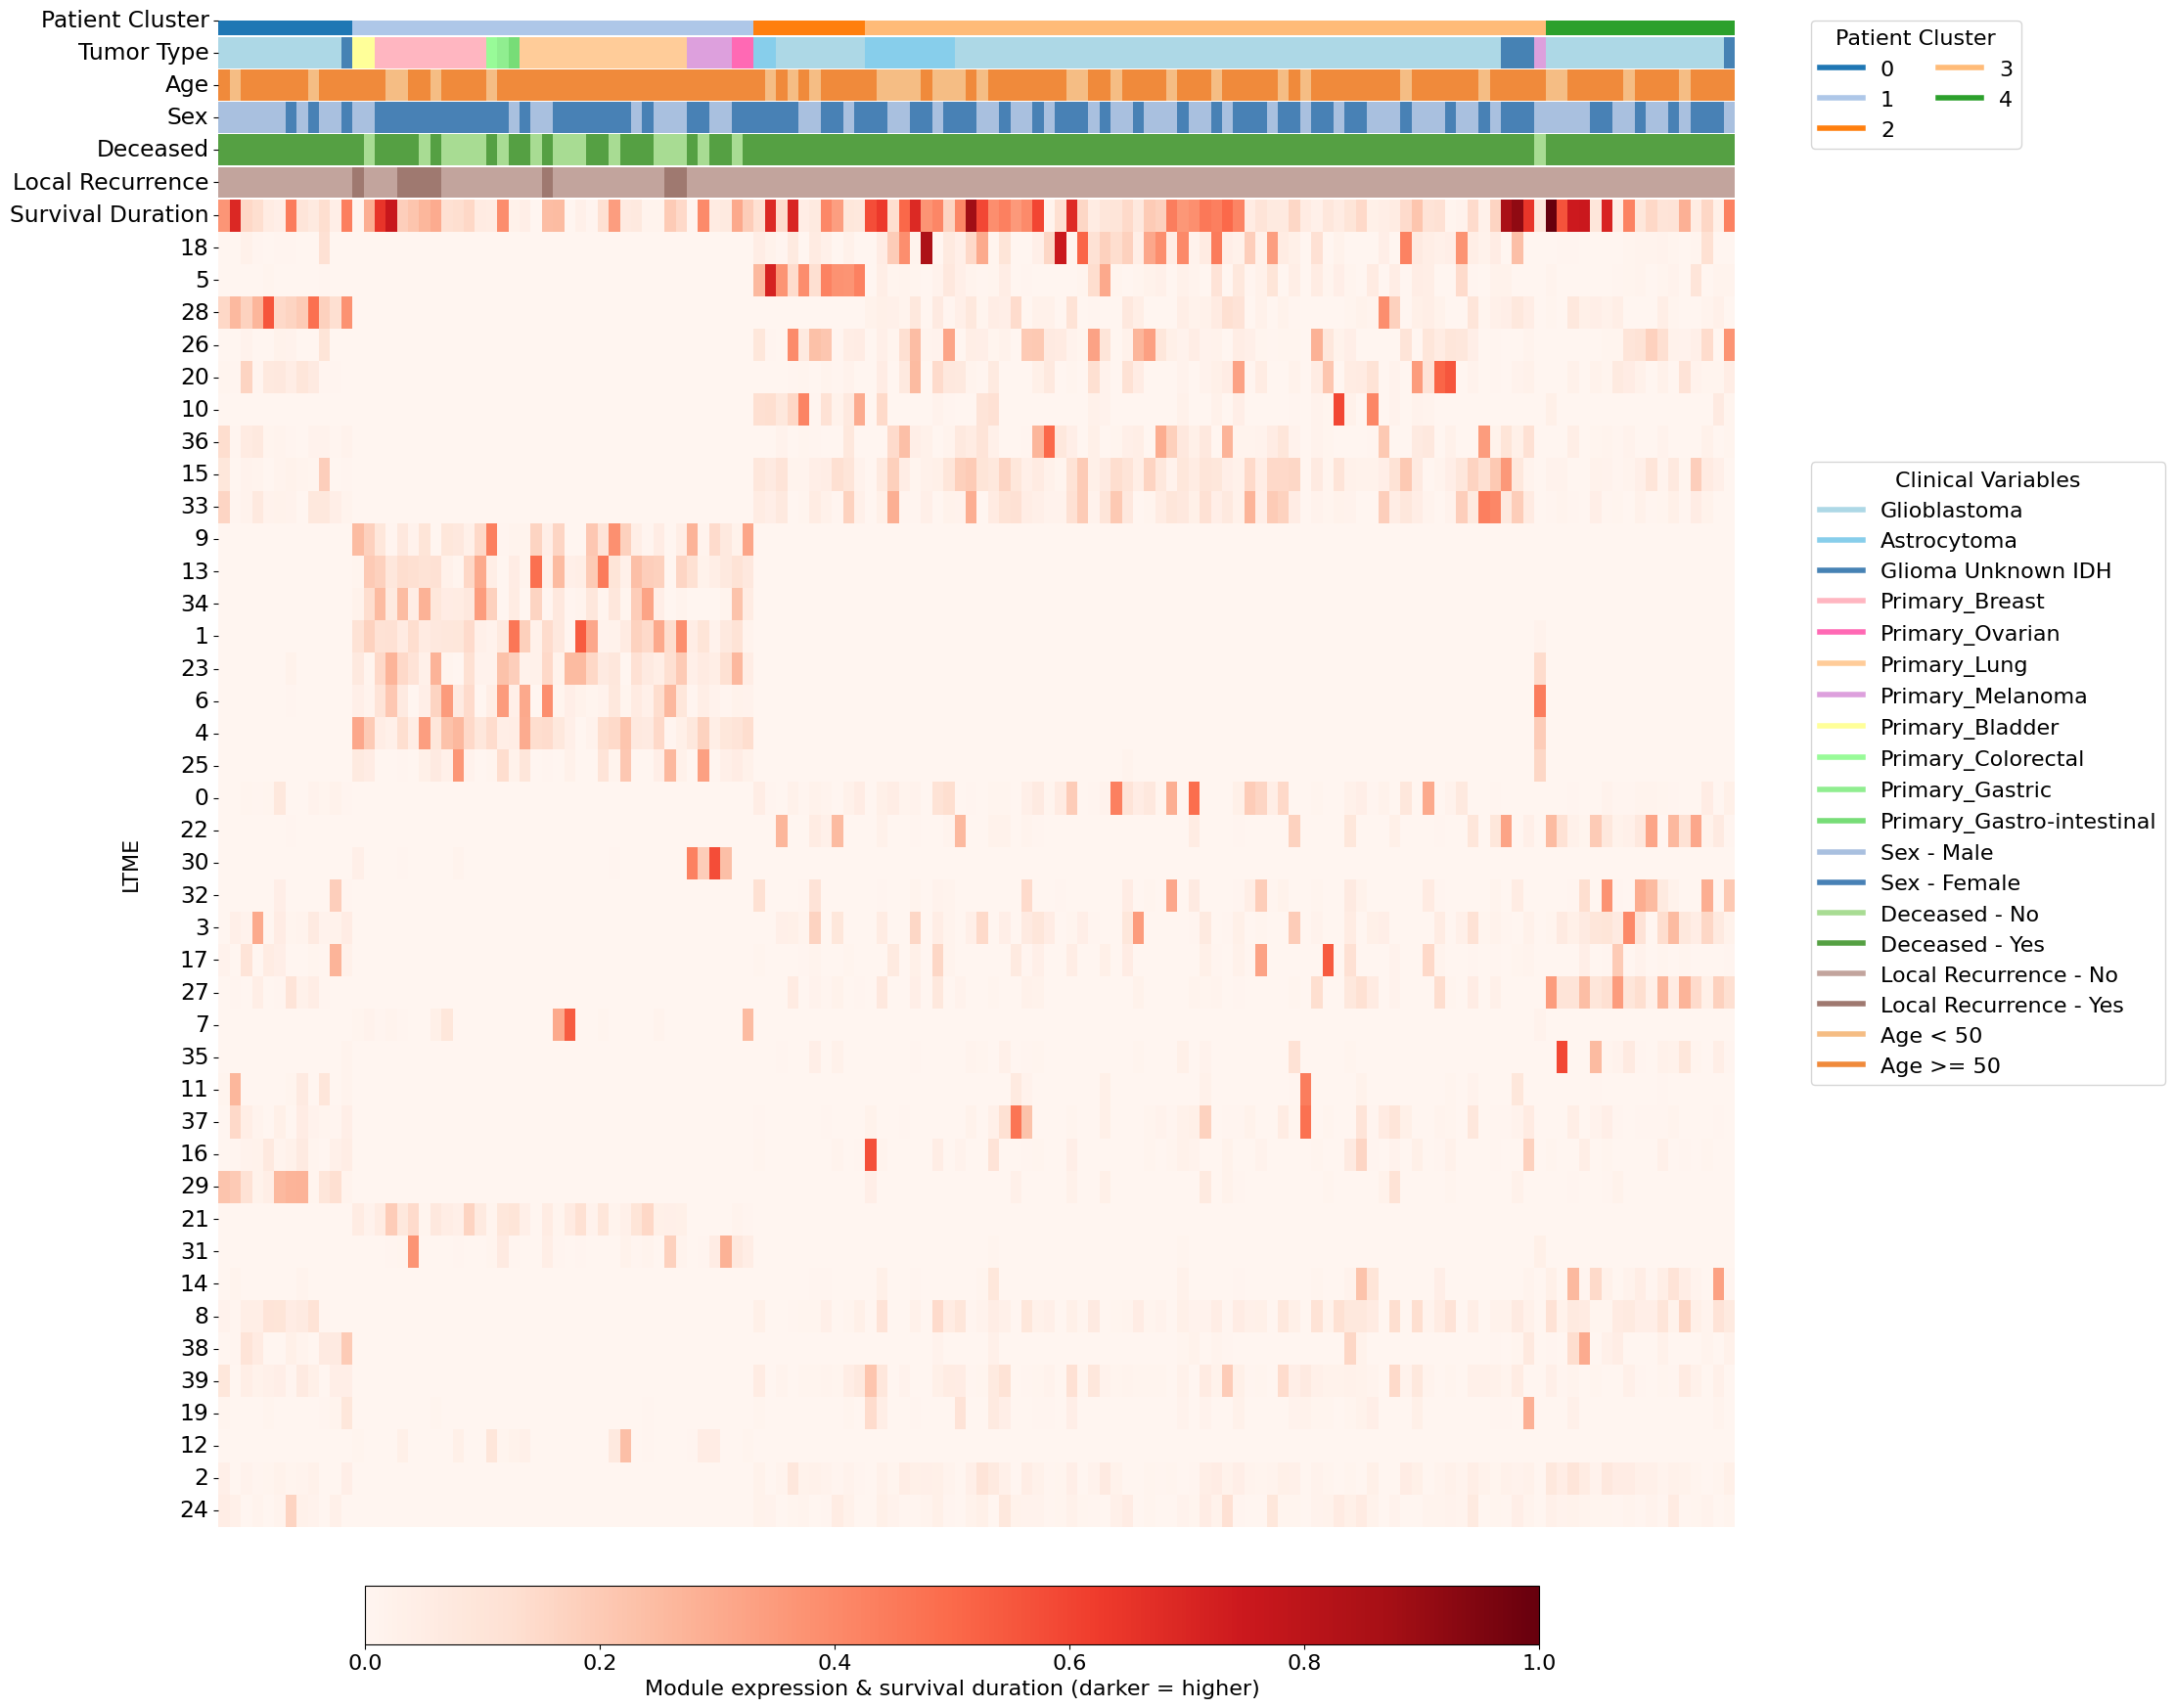

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram

if 'Sample' in labels_df.columns:
    labels_df['Patient'] = labels_df['Sample'].apply(lambda x: "_".join([x.split('_')[0], x.split('_')[1][:3]]))
    labels_df = labels_df.drop(['Sample'], axis=1)
    labels_df = labels_df.set_index('Patient')

# Create cluster counts (raw counts of cells per cluster for each patient)
cluster_counts = labels_df.groupby(['Patient', 'Cluster']).size().unstack(fill_value=0)

# Align the indices of cluster_counts with patient_df's name column
common_patients = patient_df['patient_id'].unique().tolist()
common_patients = cluster_counts.index.intersection(common_patients)

patient_df = patient_df[patient_df['patient_id'].isin(common_patients)]

# Ensure cluster_counts is also filtered to only include the matched patients
cluster_counts = cluster_counts.loc[common_patients]

# Perform clustering on the aggregated data
kmeans = KMeans(n_clusters=5, random_state=99)
patient_labels = kmeans.fit_predict(cluster_counts)
patient_df['Patient Cluster'] = patient_labels

patient_df_colormap = patient_df.copy()

# Merge with sample_label_pivot_norm (without 'Event' and 'Survival Duration')
patient_df_colormap = patient_df_colormap.merge(
    sample_label_pivot_norm[sample_label_pivot_norm['cmn'] == 'All'].drop(columns=['Event', 'Survival Duration']),
    left_on='patient_id', right_on='patient_id'
)

# Assuming patient_df and normalized_cluster_counts are already defined

patient_df_colormap.dropna(subset=['Age', 'Sex', 'Survival Duration'], inplace=True)

if 'Brain Metastasis' in patient_df_colormap.columns:
    patient_df_colormap.drop(columns=['Brain Metastasis'], inplace=True)

patient_df_colormap['Tumor Type'] = patient_df_colormap[conditions].idxmax(axis=1)

patient_df_colormap['Age'] = (patient_df_colormap['Age'] > 50).astype(int)

if (patient_df['Survival Duration'] > 1).any():
    patient_df_colormap['Survival Duration'] = (patient_df_colormap['Survival Duration'] - patient_df_colormap['Survival Duration'].min()) / (patient_df_colormap['Survival Duration'].max() - patient_df_colormap['Survival Duration'].min())

patient_df_colormap.sort_values(by=['Patient Cluster', 'Tumor Type'], inplace=True)

patient_df_colormap.columns = patient_df_colormap.columns.astype(str)

# Rename Event to Deceased
patient_df_colormap.rename(columns={'Event': 'Deceased'}, inplace=True)

# Define annotation and heatmap columns
annotation_columns = ['Patient Cluster', 'Tumor Type', 'Age', 'Sex', 'Deceased', 'Local Recurrence']
heatmap_columns = ['Survival Duration'] + list(map(str, range(n_clusters)))

# Create the new DataFrame
patient_df_colormap_combi = patient_df_colormap[annotation_columns + heatmap_columns]

# Define color maps
def create_color_map(series, palette_name):
    unique_values = series.unique()
    colors = sns.color_palette(palette_name, len(unique_values))
    return dict(zip(unique_values, colors))

patient_label_color_map = create_color_map(patient_df_colormap_combi['Patient Cluster'], "tab20")

sex_colors = {0.0: '#a9c0df', 1.0: '#4881b5'}
deceased_colors = {0: '#a8dc93', 1: '#55a043'}
local_recurrence_colors = {0: '#c2a49d', 1: '#9f7970'}
age_colors = {0: '#f5bd84', 1: '#f08a3b'}

# Define a dictionary for the colors
origin_colors = {
    'Glioblastoma': '#add8e6', 'Astrocytoma': '#87ceeb', 'Glioma Unknown IDH': '#4682b4',
    'Primary_Breast': '#ffb6c1', 'Primary_Ovarian': '#ff69b4',
    'Primary_Lung': '#ffcc99',
    'Primary_Melanoma': '#dda0dd',
    'Primary_Bladder': '#ffff99',
    'Primary_Colorectal': '#98fb98', 'Primary_Gastric': '#90ee90', 'Primary_Gastro-intestinal': '#77dd77'
}

# Hierarchical clustering
Z = linkage(patient_df_colormap_combi[heatmap_columns].T, method='average')

fig, ax = plt.subplots(figsize=(20, 20))

# Plot the dendrogram
dendro = dendrogram(Z, orientation='left', no_plot=True)
heatmap_data = patient_df_colormap_combi[heatmap_columns].T.iloc[dendro['leaves']]

sns.heatmap(heatmap_data, ax=ax, cmap="Reds", cbar=False)

# Add color annotations with spacing
def add_color_annotations(ax, row_data, start_pos, color_map, space=0.05):
    for idx, value in enumerate(row_data):
        ax.add_patch(plt.Rectangle((idx, start_pos), 1, 1 - space, color=color_map[value], ec='none'))

annotation_colors = {
    'Tumor Type': origin_colors,
    'Age': age_colors,
    'Sex': sex_colors,
    'Deceased': deceased_colors,
    'Local Recurrence': local_recurrence_colors
}

patient_label_colors = patient_label_color_map  # Separate color map for patient labels

spacing = 0.05  # spacing between annotation rows
annotation_height = 1 - spacing  # the height of each annotation row

# Calculate the y-tick positions for annotations and heatmap rows
num_annotations = len(annotation_colors) + 1  # include patient_label
y_ticks_annotations = [-num_annotations + i + (annotation_height / 2) for i in range(num_annotations)]
y_ticks_heatmap = [i + 0.5 for i in range(len(heatmap_columns))]

# Combine y-ticks and labels for annotations and heatmap
y_ticks = y_ticks_annotations + y_ticks_heatmap
y_tick_labels = ['Patient Cluster'] + list(annotation_colors.keys()) + heatmap_data.index.tolist()

# Add patient label annotations separately
add_color_annotations(ax, patient_df_colormap_combi['Patient Cluster'], y_ticks_annotations[0] - (annotation_height / 2), patient_label_colors, spacing)

# Add other annotations
for i, (col, color_map) in enumerate(annotation_colors.items(), start=1):
    add_color_annotations(ax, patient_df_colormap_combi[col], y_ticks_annotations[i] - (annotation_height / 2), color_map, spacing)

legend_fontsize = 16

# Create legends
legend_elements_patient_label = [plt.Line2D([0], [0], color=color, lw=4) for color in patient_label_colors.values()]
legend_labels_patient_label = list(patient_label_colors.keys())
patient_label_legend = ax.legend(legend_elements_patient_label, legend_labels_patient_label, title="Patient Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2, title_fontsize=legend_fontsize, fontsize=legend_fontsize)

legend_elements_others = [plt.Line2D([0], [0], color=color, lw=4) for color in [*origin_colors.values(), *sex_colors.values(), *deceased_colors.values(), *local_recurrence_colors.values(), *age_colors.values()]]
legend_labels_others = list(origin_colors.keys()) + ['Sex - Male', 'Sex - Female', 'Deceased - No', 'Deceased - Yes', 'Local Recurrence - No', 'Local Recurrence - Yes', 'Age < 50', 'Age >= 50']
other_annotations_legend = ax.legend(legend_elements_others, legend_labels_others, title="Clinical Variables", bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0., title_fontsize=legend_fontsize, fontsize=legend_fontsize)

# Add the patient_label_legend back after adding other_annotations_legend
ax.add_artist(patient_label_legend)

# Customize the axes
ax.set_xticks([])
ax.set_xticklabels([])

ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels, va='center', fontsize=14 * 1.2)  # Increase font size by 20%

# Remove tick lines and hide x-axis
ax.tick_params(axis='x', which='both', length=0)
ax.xaxis.set_visible(False)

# Adjust "Module" text to move further to the left
ax.text(-7, len(heatmap_columns)/2, 'LTME', rotation=90, va='center', ha='right', fontsize=16, color='black')

cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(ax.collections[0], cax=cbar_ax, orientation='horizontal')
cbar.set_label('Module expression & survival duration (darker = higher)', fontsize=16)

# Set the colorbar tick labels font size to 16
cbar.ax.tick_params(labelsize=16)

plt.show()


## UMAP

In [ ]:
import umap

np.random.seed(99)

# Reduce dimensionality using UMAP
umap_reducer = umap.UMAP(random_state=99)
embedding_umap = umap_reducer.fit_transform(embedding_mean)

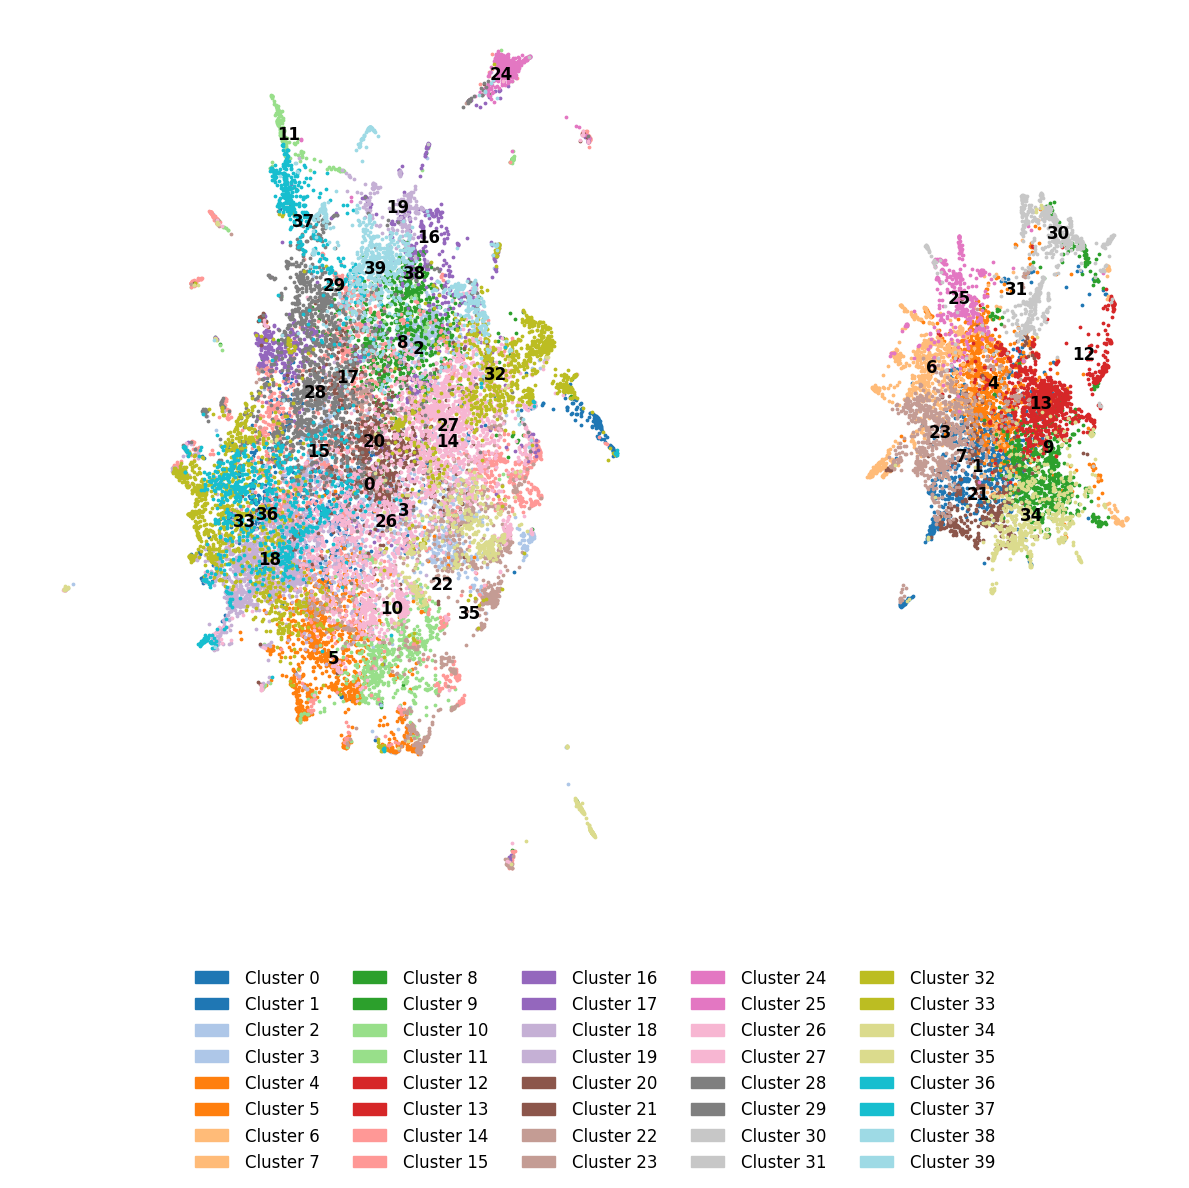

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Assuming embedding_umap and labels are defined

# Get unique clusters and create a color map for clusters
unique_clusters = np.unique(labels)
cluster_colors = plt.get_cmap('tab20')(np.linspace(0, 1, len(unique_clusters)))
cluster_color_map = dict(zip(unique_clusters, cluster_colors))

# Plot UMAP colored by clusters
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the UMAP embeddings by clusters (marker size 3, color by cluster)
for cluster, color in cluster_color_map.items():
    idx = labels == cluster
    ax.scatter(embedding_umap[idx, 0], embedding_umap[idx, 1], color=color, label=f'Cluster {cluster}', s=3, alpha=1, marker='o')

# Calculate and plot the cluster numbers at approximate cluster centers
for cluster in unique_clusters:
    cluster_indices = np.where(labels == cluster)[0]
    if len(cluster_indices) > 0:
        cluster_center = np.mean(embedding_umap[cluster_indices], axis=0)
        if np.isfinite(cluster_center).all():
            ax.text(cluster_center[0], cluster_center[1], str(cluster), fontsize=12, color='black',
                    ha='center', va='center', fontweight='bold')

# Remove the title, box, and axis
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

# Create legend for clusters
handles, plot_labels = ax.get_legend_handles_labels()
rectangle_handles = [Rectangle((0, 0), 1, 1, color=handle.get_facecolor()[0]) for handle in handles]

# Adjust legend to have no title, use rectangular icons, remove the frame, and position it underneath the plot
legend = ax.legend(rectangle_handles, plot_labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),
                   ncol=5, fontsize=12, handletextpad=1, frameon=False)

plt.tight_layout()
plt.show()